In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pandas as pd

In [9]:
import random
import joblib
import os
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
PATH = '../datasets/processed/combined_salon_data_bootstrap_6000.csv'
TARGET = 'Прическа'
df = pd.read_csv(PATH)
cat_cols = [c for c in df.columns if c != TARGET]
ord_enc = OrdinalEncoder( dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1 )
X = ord_enc.fit_transform(df[cat_cols])
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df[TARGET]).astype(np.int64)

os.makedirs("ml/artifacts", exist_ok=True)
joblib.dump(ord_enc, "ml/artifacts/feature_encoder.joblib")
joblib.dump(lbl_enc, "ml/artifacts/label_encoder.joblib")

['ml/artifacts/label_encoder.joblib']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

class SalonDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.as_tensor(X)
        self.y = torch.as_tensor(y)

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
BATCH_SIZE = 32

train_loader = DataLoader(SalonDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(SalonDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class StyleNet(nn.Module):
    def __init__(self, cards, n_cls, emb_dim=12):
        super().__init__()
        self.em = nn.ModuleList(
            [nn.Embedding(c+1, min(emb_dim, (c+1)//2)) for c in cards]
        )
        h = sum(e.embedding_dim for e in self.em)

        self.net = nn.Sequential(
            nn.LayerNorm(h),
            nn.Dropout(0.30),
            nn.Linear(h, 128), nn.GELU(),
            nn.Linear(128, 64), nn.GELU(),
            nn.Dropout(0.30),
            nn.Linear(64, n_cls)
        )

    def forward(self, x):
        x = torch.cat([e(x[:, i]) for i, e in enumerate(self.em)], 1)
        return self.net(x)

In [30]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cardinalities = [int(cat.max() + 1) for cat in ord_enc.transform(df[cat_cols]).T]
n_classes = len(lbl_enc.classes_)
model = StyleNet(cardinalities, n_classes).to(DEVICE)
opt    = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=3e-3)
sched  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=.3, patience=3)
crit   = nn.CrossEntropyLoss(label_smoothing=0.05)

In [31]:
import collections
import torch, torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

# ───────────────── helper ─────────────────
def top_k_acc(logits: torch.Tensor, y: torch.Tensor, k: int = 3) -> float:
    """Top-k accuracy (k=3 по умолчанию)."""
    topk = logits.topk(k, dim=1).indices          # [B,k]
    return (topk == y[:, None]).any(1).float().mean().item()

# ───────────────── training loop ─────────────────
def train_with_top3(model, train_loader, val_loader,
                    criterion, optimizer, scheduler=None,
                    epochs: int = 30, device: str = "cuda",
                    patience: int = 6):
    """Обучает модель и выводит Top-3 accuracy.

    Возвращает: history (dict) с loss, acc, f1, top3.
    """
    history = collections.defaultdict(list)
    best_loss, bad_epochs = float("inf"), 0

    for ep in range(1, epochs + 1):
        # -------- train --------
        model.train()
        t_loss, t_ok, n = 0.0, 0, 0
        for xb, yb in tqdm(train_loader, desc=f"train {ep:02d}", leave=False):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            optimizer.zero_grad()

            logits = model(xb)
            loss   = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
            optimizer.step()

            t_loss += loss.item() * yb.size(0)
            t_ok   += (logits.argmax(1) == yb).sum().item()
            n      += yb.size(0)

        # -------- validate --------
        model.eval()
        v_loss, y_true, y_pred, y_logits = 0.0, [], [], []
        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc="valid", leave=False):
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                logits = model(xb)

                v_loss += criterion(logits, yb).item() * yb.size(0)
                y_true.extend(yb.cpu().tolist())
                y_pred.extend(logits.argmax(1).cpu().tolist())
                y_logits.append(logits.cpu())

        y_logits = torch.cat(y_logits)
        val_acc  = accuracy_score(y_true, y_pred)
        val_f1   = f1_score(y_true, y_pred, average="macro")
        val_top3 = top_k_acc(y_logits, torch.tensor(y_true), k=3)

        # -------- bookkeeping --------
        history["train_loss"].append(t_loss / n)
        history["val_loss"].append(v_loss / len(y_true))
        history["train_acc"].append(t_ok / n)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["val_top3"].append(val_top3)

        print(f"Ep {ep:02d} | "
              f"loss T/V {t_loss/n:.3f}/{v_loss/len(y_true):.3f} | "
              f"acc T/V {t_ok/n:.3f}/{val_acc:.3f} | "
              f"F1 {val_f1:.3f} | Top-3 {val_top3:.3f}")

        # scheduler & early-stop
        if scheduler: scheduler.step(v_loss / len(y_true))
        if v_loss < best_loss - 1e-4:
            best_loss, bad_epochs = v_loss, 0
            torch.save(model.state_dict(), "ml/artifacts/best_model.pt")
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print("⏹ early stopping")
                break

    return history


In [32]:
history = train_with_top3(model, train_loader, test_loader,
                          crit, opt, scheduler=sched,
                          epochs=50, device=DEVICE)

Ep 01 | loss T/V 2.030/1.690 | acc T/V 0.324/0.471 | F1 0.347 | Top-3 0.786


Ep 02 | loss T/V 1.800/1.543 | acc T/V 0.417/0.531 | F1 0.430 | Top-3 0.832


Ep 03 | loss T/V 1.706/1.496 | acc T/V 0.447/0.556 | F1 0.459 | Top-3 0.851


Ep 04 | loss T/V 1.644/1.441 | acc T/V 0.475/0.568 | F1 0.493 | Top-3 0.856


Ep 05 | loss T/V 1.615/1.436 | acc T/V 0.480/0.568 | F1 0.507 | Top-3 0.856


Ep 06 | loss T/V 1.595/1.408 | acc T/V 0.495/0.573 | F1 0.502 | Top-3 0.860


Ep 07 | loss T/V 1.587/1.413 | acc T/V 0.500/0.573 | F1 0.502 | Top-3 0.862


Ep 08 | loss T/V 1.558/1.408 | acc T/V 0.513/0.573 | F1 0.511 | Top-3 0.871


Ep 09 | loss T/V 1.545/1.389 | acc T/V 0.509/0.580 | F1 0.514 | Top-3 0.863


Ep 10 | loss T/V 1.540/1.382 | acc T/V 0.516/0.578 | F1 0.511 | Top-3 0.873


Ep 11 | loss T/V 1.522/1.372 | acc T/V 0.514/0.582 | F1 0.507 | Top-3 0.872


Ep 12 | loss T/V 1.499/1.355 | acc T/V 0.522/0.587 | F1 0.491 | Top-3 0.883


Ep 13 | loss T/V 1.495/1.368 | acc T/V 0.518/0.588 | F1 0.511 | Top-3 0.873


Ep 14 | loss T/V 1.486/1.361 | acc T/V 0.534/0.583 | F1 0.521 | Top-3 0.877


Ep 15 | loss T/V 1.503/1.381 | acc T/V 0.525/0.573 | F1 0.503 | Top-3 0.863


Ep 16 | loss T/V 1.468/1.352 | acc T/V 0.539/0.578 | F1 0.518 | Top-3 0.882


Ep 17 | loss T/V 1.481/1.360 | acc T/V 0.543/0.587 | F1 0.492 | Top-3 0.877


Ep 18 | loss T/V 1.468/1.366 | acc T/V 0.541/0.575 | F1 0.503 | Top-3 0.876


Ep 19 | loss T/V 1.461/1.349 | acc T/V 0.543/0.584 | F1 0.515 | Top-3 0.875


Ep 20 | loss T/V 1.472/1.361 | acc T/V 0.536/0.587 | F1 0.533 | Top-3 0.879


Ep 21 | loss T/V 1.451/1.343 | acc T/V 0.544/0.586 | F1 0.524 | Top-3 0.881


Ep 22 | loss T/V 1.445/1.353 | acc T/V 0.551/0.580 | F1 0.520 | Top-3 0.875


Ep 23 | loss T/V 1.430/1.360 | acc T/V 0.558/0.576 | F1 0.515 | Top-3 0.868


Ep 24 | loss T/V 1.456/1.361 | acc T/V 0.540/0.574 | F1 0.517 | Top-3 0.870


Ep 25 | loss T/V 1.445/1.356 | acc T/V 0.553/0.582 | F1 0.517 | Top-3 0.867


Ep 26 | loss T/V 1.404/1.346 | acc T/V 0.559/0.580 | F1 0.516 | Top-3 0.874


Ep 27 | loss T/V 1.409/1.340 | acc T/V 0.561/0.584 | F1 0.524 | Top-3 0.879


Ep 28 | loss T/V 1.395/1.344 | acc T/V 0.569/0.587 | F1 0.530 | Top-3 0.872


Ep 29 | loss T/V 1.393/1.343 | acc T/V 0.569/0.585 | F1 0.518 | Top-3 0.872


Ep 30 | loss T/V 1.378/1.347 | acc T/V 0.573/0.585 | F1 0.515 | Top-3 0.873


Ep 31 | loss T/V 1.384/1.339 | acc T/V 0.565/0.580 | F1 0.519 | Top-3 0.877


Ep 32 | loss T/V 1.393/1.343 | acc T/V 0.560/0.582 | F1 0.525 | Top-3 0.876


Ep 33 | loss T/V 1.389/1.342 | acc T/V 0.566/0.586 | F1 0.529 | Top-3 0.874


Ep 34 | loss T/V 1.389/1.339 | acc T/V 0.568/0.592 | F1 0.530 | Top-3 0.875


Ep 35 | loss T/V 1.392/1.340 | acc T/V 0.566/0.593 | F1 0.527 | Top-3 0.869


Ep 36 | loss T/V 1.373/1.335 | acc T/V 0.574/0.592 | F1 0.524 | Top-3 0.872


Ep 37 | loss T/V 1.380/1.336 | acc T/V 0.571/0.588 | F1 0.523 | Top-3 0.874


Ep 38 | loss T/V 1.373/1.334 | acc T/V 0.572/0.592 | F1 0.526 | Top-3 0.876


Ep 39 | loss T/V 1.377/1.335 | acc T/V 0.568/0.590 | F1 0.523 | Top-3 0.877


Ep 40 | loss T/V 1.358/1.335 | acc T/V 0.584/0.588 | F1 0.523 | Top-3 0.877


Ep 41 | loss T/V 1.377/1.333 | acc T/V 0.572/0.587 | F1 0.520 | Top-3 0.876


Ep 42 | loss T/V 1.374/1.337 | acc T/V 0.574/0.584 | F1 0.523 | Top-3 0.873


Ep 43 | loss T/V 1.361/1.336 | acc T/V 0.588/0.585 | F1 0.523 | Top-3 0.874


Ep 44 | loss T/V 1.373/1.337 | acc T/V 0.569/0.583 | F1 0.521 | Top-3 0.873


Ep 45 | loss T/V 1.363/1.338 | acc T/V 0.578/0.583 | F1 0.522 | Top-3 0.872


Ep 46 | loss T/V 1.354/1.338 | acc T/V 0.580/0.582 | F1 0.521 | Top-3 0.873


Ep 47 | loss T/V 1.359/1.337 | acc T/V 0.572/0.583 | F1 0.520 | Top-3 0.873
⏹ early stopping


In [78]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Построить графики метрик обучения.

    Параметры:
        history (dict): словарь с ключами
            'train_loss', 'test_loss',
            'train_acc', 'test_acc', 'test_f1'
            и списками значений на каждую эпоху.
    """
    epochs = list(range(1, len(history['train_loss']) + 1))

    # 1) Loss
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'],  label='test_loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.show()

    # 2) Accuracy
    plt.figure()
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'],  label='test_acc')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.show()

    # 3) Macro F1
    plt.figure()
    plt.plot(epochs, history['val_top3'], label='test_f1')
    plt.xlabel('Эпоха')
    plt.ylabel('Test Top3')
    plt.title('Test Top3-score')
    plt.legend()
    plt.show()

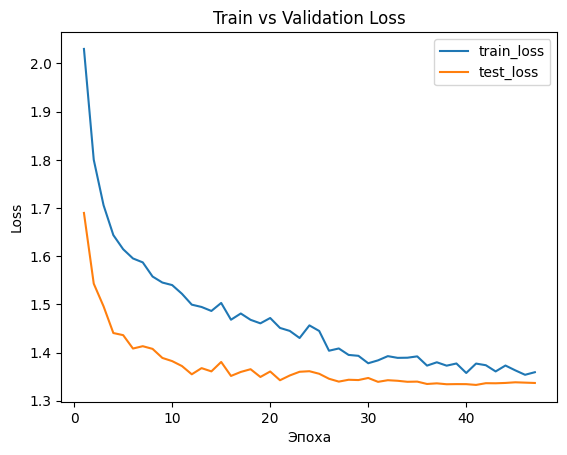

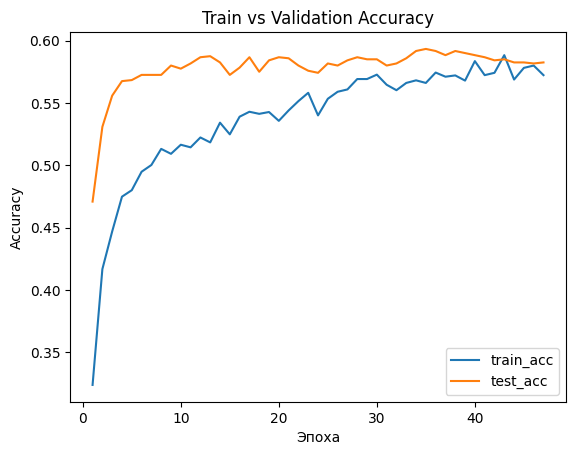

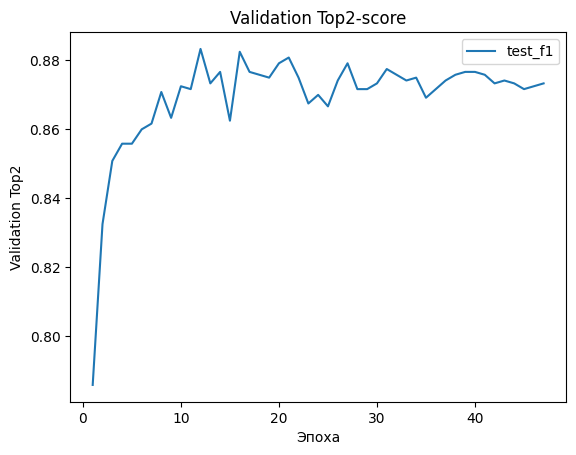

In [33]:

# Пример использования:
plot_history(history)


In [46]:
class StyleNet2(nn.Module):
    def __init__(self, cards, n_cls, emb_dim=10):
        super().__init__()
        self.em = nn.ModuleList(
            [nn.Embedding(c+1, min(emb_dim, (c+1)//2)) for c in cards]
        )
        h = sum(e.embedding_dim for e in self.em)

        self.net = nn.Sequential(
            nn.LayerNorm(h),
            nn.Dropout(0.30),
            nn.Linear(h, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(256, n_cls)
        )

    def forward(self, x):
        x = torch.cat([e(x[:, i]) for i, e in enumerate(self.em)], 1)
        return self.net(x)

cardinalities = [int(cat.max() + 1) for cat in ord_enc.transform(df[cat_cols]).T]
n_classes = len(lbl_enc.classes_)
model2 = StyleNet2(cardinalities, n_classes).to(DEVICE)
opt    = torch.optim.AdamW(model2.parameters(), lr=1e-3, weight_decay=3e-3)
sched  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=.3, patience=3)
crit   = nn.CrossEntropyLoss(label_smoothing=0.05)

In [47]:
history2 = train_with_top3(model2, train_loader, test_loader,
                          crit, opt, scheduler=sched,
                          epochs=50, device=DEVICE)

Ep 01 | loss T/V 2.050/1.682 | acc T/V 0.306/0.488 | F1 0.355 | Top-3 0.796


Ep 02 | loss T/V 1.783/1.561 | acc T/V 0.406/0.519 | F1 0.406 | Top-3 0.849


Ep 03 | loss T/V 1.707/1.489 | acc T/V 0.432/0.541 | F1 0.431 | Top-3 0.852


Ep 04 | loss T/V 1.672/1.456 | acc T/V 0.449/0.578 | F1 0.485 | Top-3 0.850


Ep 05 | loss T/V 1.630/1.444 | acc T/V 0.469/0.562 | F1 0.471 | Top-3 0.857


Ep 06 | loss T/V 1.616/1.439 | acc T/V 0.480/0.556 | F1 0.466 | Top-3 0.864


Ep 07 | loss T/V 1.580/1.410 | acc T/V 0.482/0.585 | F1 0.503 | Top-3 0.870


Ep 08 | loss T/V 1.566/1.393 | acc T/V 0.493/0.574 | F1 0.476 | Top-3 0.878


Ep 09 | loss T/V 1.554/1.398 | acc T/V 0.512/0.578 | F1 0.487 | Top-3 0.874


Ep 10 | loss T/V 1.536/1.388 | acc T/V 0.500/0.575 | F1 0.481 | Top-3 0.873


Ep 11 | loss T/V 1.529/1.389 | acc T/V 0.509/0.573 | F1 0.480 | Top-3 0.884


Ep 12 | loss T/V 1.511/1.382 | acc T/V 0.510/0.571 | F1 0.495 | Top-3 0.884


Ep 13 | loss T/V 1.503/1.367 | acc T/V 0.515/0.586 | F1 0.509 | Top-3 0.879


Ep 14 | loss T/V 1.499/1.361 | acc T/V 0.524/0.580 | F1 0.504 | Top-3 0.889


Ep 15 | loss T/V 1.487/1.353 | acc T/V 0.528/0.589 | F1 0.513 | Top-3 0.881


Ep 16 | loss T/V 1.462/1.370 | acc T/V 0.533/0.579 | F1 0.508 | Top-3 0.881


Ep 17 | loss T/V 1.476/1.356 | acc T/V 0.530/0.587 | F1 0.512 | Top-3 0.879


Ep 18 | loss T/V 1.457/1.350 | acc T/V 0.544/0.595 | F1 0.517 | Top-3 0.887


Ep 19 | loss T/V 1.471/1.357 | acc T/V 0.540/0.588 | F1 0.509 | Top-3 0.885


Ep 20 | loss T/V 1.457/1.346 | acc T/V 0.537/0.584 | F1 0.519 | Top-3 0.894


Ep 21 | loss T/V 1.463/1.357 | acc T/V 0.538/0.579 | F1 0.494 | Top-3 0.887


Ep 22 | loss T/V 1.447/1.352 | acc T/V 0.539/0.581 | F1 0.510 | Top-3 0.886


Ep 23 | loss T/V 1.444/1.354 | acc T/V 0.539/0.591 | F1 0.535 | Top-3 0.892


Ep 24 | loss T/V 1.439/1.359 | acc T/V 0.548/0.594 | F1 0.528 | Top-3 0.892


Ep 25 | loss T/V 1.413/1.340 | acc T/V 0.553/0.586 | F1 0.517 | Top-3 0.891


Ep 26 | loss T/V 1.407/1.335 | acc T/V 0.555/0.589 | F1 0.526 | Top-3 0.897


Ep 27 | loss T/V 1.414/1.337 | acc T/V 0.560/0.592 | F1 0.527 | Top-3 0.892


Ep 28 | loss T/V 1.410/1.337 | acc T/V 0.557/0.593 | F1 0.534 | Top-3 0.892


Ep 29 | loss T/V 1.403/1.339 | acc T/V 0.554/0.585 | F1 0.525 | Top-3 0.895


Ep 30 | loss T/V 1.388/1.336 | acc T/V 0.566/0.586 | F1 0.521 | Top-3 0.892


Ep 31 | loss T/V 1.382/1.330 | acc T/V 0.572/0.588 | F1 0.528 | Top-3 0.893


Ep 32 | loss T/V 1.402/1.331 | acc T/V 0.553/0.588 | F1 0.527 | Top-3 0.895


Ep 33 | loss T/V 1.386/1.330 | acc T/V 0.573/0.593 | F1 0.535 | Top-3 0.896


Ep 34 | loss T/V 1.375/1.330 | acc T/V 0.572/0.593 | F1 0.536 | Top-3 0.897


Ep 35 | loss T/V 1.384/1.331 | acc T/V 0.565/0.592 | F1 0.536 | Top-3 0.892


Ep 36 | loss T/V 1.386/1.330 | acc T/V 0.560/0.592 | F1 0.537 | Top-3 0.892


Ep 37 | loss T/V 1.383/1.331 | acc T/V 0.567/0.588 | F1 0.531 | Top-3 0.894


Ep 38 | loss T/V 1.361/1.330 | acc T/V 0.568/0.590 | F1 0.527 | Top-3 0.893


Ep 39 | loss T/V 1.371/1.330 | acc T/V 0.567/0.592 | F1 0.536 | Top-3 0.893
⏹ early stopping


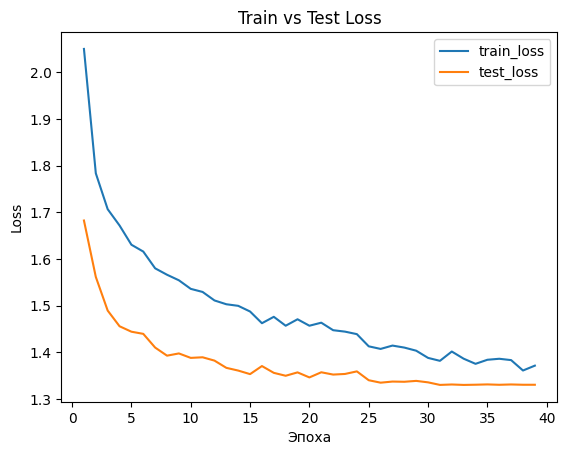

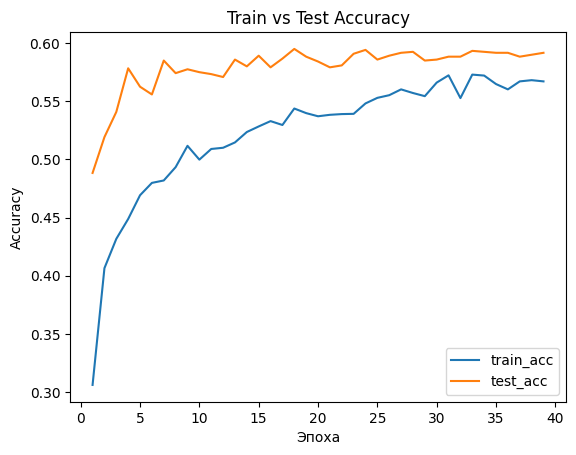

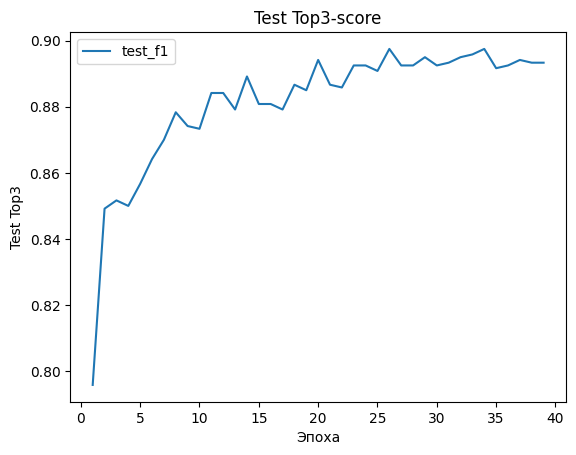

In [79]:
plot_history(history2)

In [80]:
torch.save({'state_dict': model2.state_dict(),
            'cardinalities': cardinalities}, "ml/artifacts/stylenet.pt")
#pd.DataFrame(history).to_csv("ml/artifacts/train_log.csv", index=False)
#print("done; weights & log saved")